In [1]:
import torch
import numpy as np
from hmc_u1 import HMC_U1
from hmc_u1_ft import HMC_U1_FT
from cnn_model import FieldTransformation
from utils import hmc_summary


In [2]:
# Parameters
lattice_size = 16
volume = lattice_size ** 2
beta = 5
n_thermalization_steps = 200
n_steps = 50
step_size = 0.1
n_iterations = 512

# Initialize device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

# Set default type
torch.set_default_dtype(torch.float32)

### No Field Transformation

>>> No Field Transformation HMC Simulation: 


Running HMC: 100%|██████████| 512/512 [00:05<00:00, 86.39it/s]


>>> Simulation completed


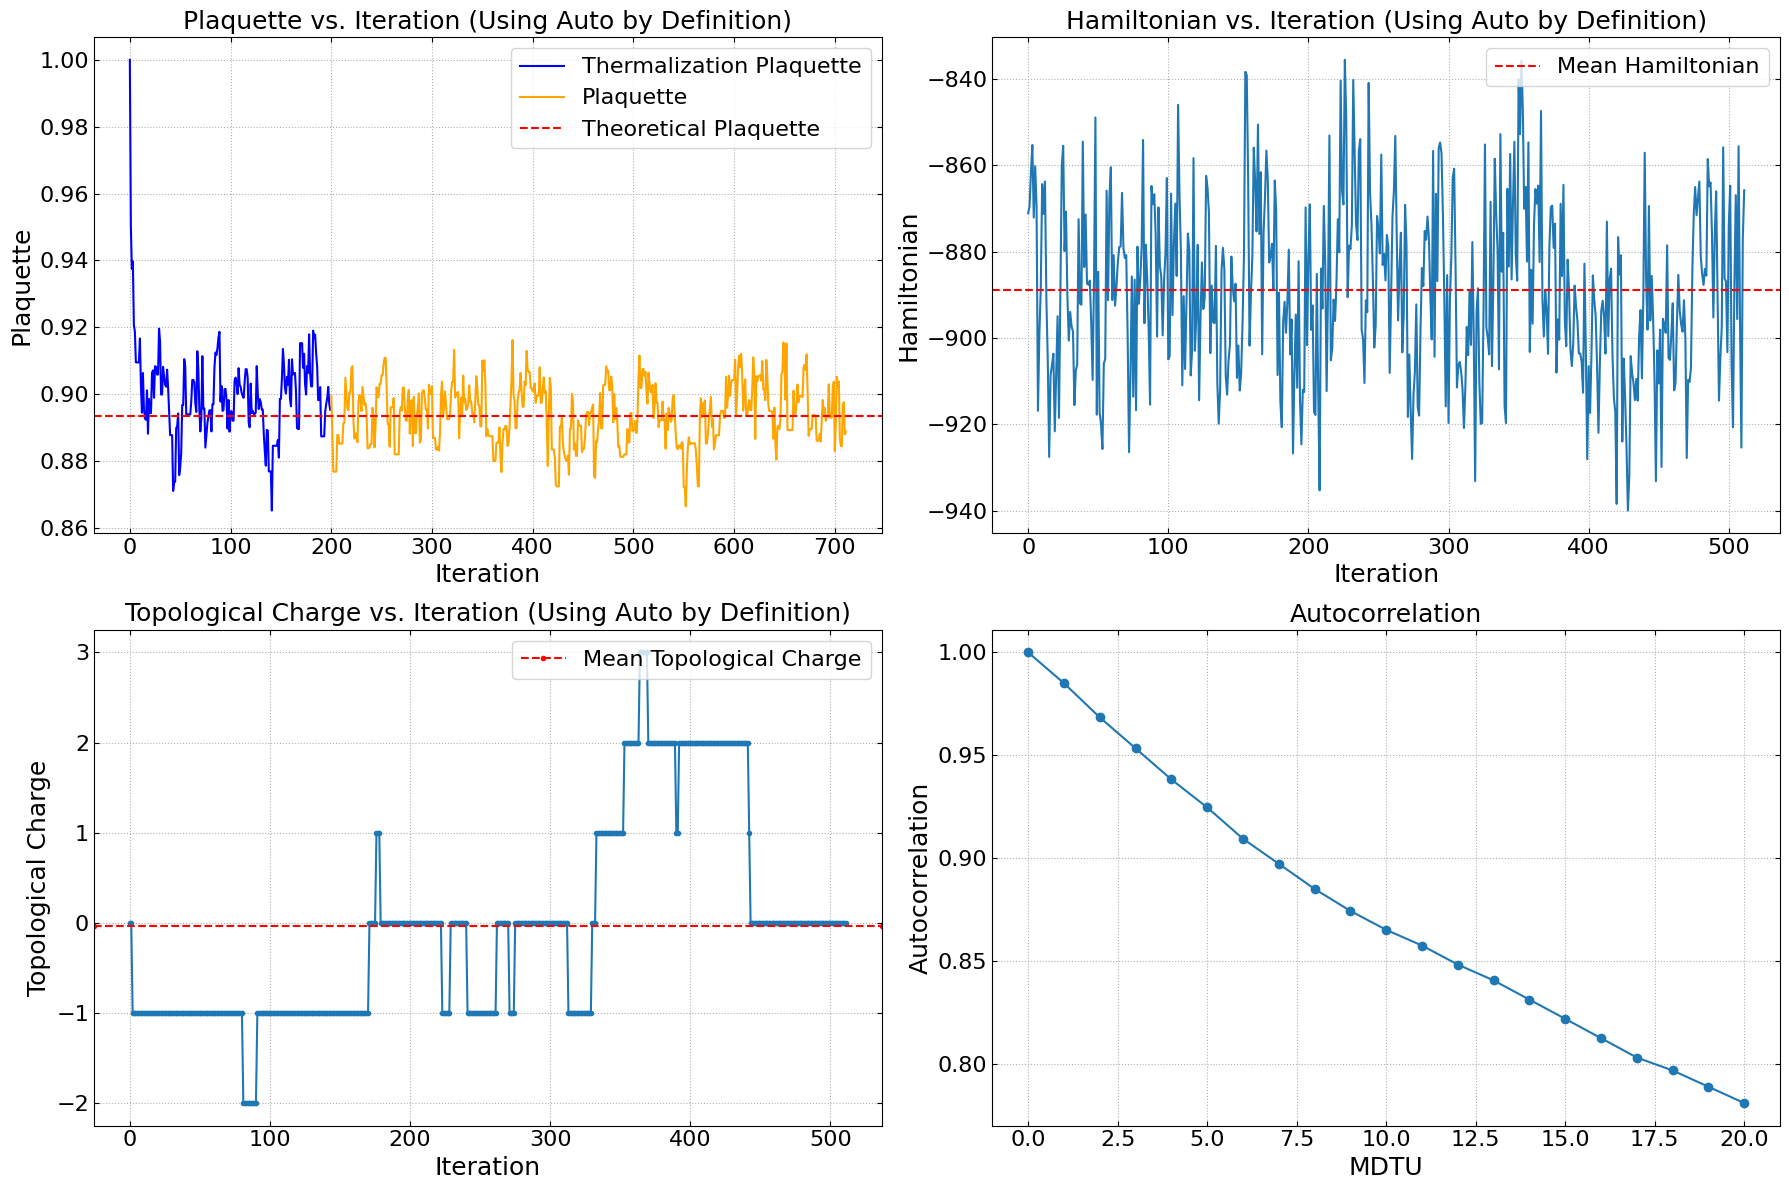

>>> Theoretical plaquette:  0.8933831370440852
>>> Mean plaq:  0.8940275878412649
>>> Std of mean plaq:  0.00038708332705635545
Thermalization acceptance rate: 0.8150
Acceptance rate: 0.7637


In [3]:
print(">>> No Field Transformation HMC Simulation: ")

# Initialize HMC
hmc = HMC_U1(lattice_size, beta, n_thermalization_steps, n_steps, step_size, device=device)

# Thermalize the system
theta_thermalized, therm_plaq_ls, therm_acceptance_rate = hmc.thermalize()

# Run HMC without field transformation
config_ls, plaq_ls, acceptance_rate, topological_charges, hamiltonians = hmc.run(n_iterations, theta_thermalized)

print(">>> Simulation completed")


# Compute autocorrelation of topological charges
max_lag = 20
hmc_summary(beta, max_lag, volume, therm_plaq_ls, plaq_ls, topological_charges, hamiltonians, therm_acceptance_rate, acceptance_rate)

# Save configurations for training
np.save('dump/theta_ori.npy', torch.stack(config_ls).detach().cpu().numpy())


### Neural Network Field Transformation

>>> Neural Network Field Transformation HMC Simulation: 


/home/jinchen/miniconda3/envs/lat/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Loaded data shape: torch.Size([512, 2, 16, 16])
Training data shape: torch.Size([409, 2, 16, 16])
Testing data shape: torch.Size([103, 2, 16, 16])
>>> Training the model


Training epochs:   5%|▌         | 1/20 [00:01<00:27,  1.46s/it]

Epoch 1/20 - Train Loss: 8.232589 - Test Loss: 7.633905


Training epochs:  10%|█         | 2/20 [00:02<00:25,  1.43s/it]

Epoch 2/20 - Train Loss: 7.885836 - Test Loss: 7.330450


Training epochs:  15%|█▌        | 3/20 [00:04<00:24,  1.45s/it]

Epoch 3/20 - Train Loss: 7.645352 - Test Loss: 7.177567


Training epochs:  20%|██        | 4/20 [00:05<00:23,  1.47s/it]

Epoch 4/20 - Train Loss: 7.553731 - Test Loss: 7.143661


Training epochs:  25%|██▌       | 5/20 [00:07<00:22,  1.49s/it]

Epoch 5/20 - Train Loss: 7.536963 - Test Loss: 7.139780


Training epochs:  30%|███       | 6/20 [00:08<00:20,  1.49s/it]

Epoch 6/20 - Train Loss: 7.536186 - Test Loss: 7.138876


Training epochs:  35%|███▌      | 7/20 [00:10<00:19,  1.51s/it]

Epoch 7/20 - Train Loss: 7.534538 - Test Loss: 7.138300


Training epochs:  40%|████      | 8/20 [00:11<00:18,  1.51s/it]

Epoch 8/20 - Train Loss: 7.534651 - Test Loss: 7.138325


Training epochs:  45%|████▌     | 9/20 [00:13<00:16,  1.50s/it]

Epoch 9/20 - Train Loss: 7.534440 - Test Loss: 7.138074


Training epochs:  50%|█████     | 10/20 [00:14<00:15,  1.51s/it]

Epoch 10/20 - Train Loss: 7.531905 - Test Loss: 7.138056


Training epochs:  55%|█████▌    | 11/20 [00:16<00:13,  1.54s/it]

Epoch 11/20 - Train Loss: 7.534478 - Test Loss: 7.137787


Training epochs:  60%|██████    | 12/20 [00:18<00:12,  1.57s/it]

Epoch 12/20 - Train Loss: 7.533380 - Test Loss: 7.137561


Training epochs:  65%|██████▌   | 13/20 [00:19<00:10,  1.56s/it]

Epoch 13/20 - Train Loss: 7.531934 - Test Loss: 7.137245


Training epochs:  70%|███████   | 14/20 [00:21<00:09,  1.56s/it]

Epoch 14/20 - Train Loss: 7.532875 - Test Loss: 7.137235


Training epochs:  75%|███████▌  | 15/20 [00:22<00:07,  1.55s/it]

Epoch 15/20 - Train Loss: 7.532531 - Test Loss: 7.137121


Training epochs:  80%|████████  | 16/20 [00:24<00:06,  1.55s/it]

Epoch 16/20 - Train Loss: 7.533007 - Test Loss: 7.136748


Training epochs:  85%|████████▌ | 17/20 [00:25<00:04,  1.54s/it]

Epoch 17/20 - Train Loss: 7.532639 - Test Loss: 7.136571


Training epochs:  90%|█████████ | 18/20 [00:27<00:03,  1.53s/it]

Epoch 18/20 - Train Loss: 7.531846 - Test Loss: 7.136406


Training epochs:  95%|█████████▌| 19/20 [00:28<00:01,  1.54s/it]

Epoch 19/20 - Train Loss: 7.531684 - Test Loss: 7.136010


Training epochs: 100%|██████████| 20/20 [00:30<00:00,  1.53s/it]


Epoch 20/20 - Train Loss: 7.531469 - Test Loss: 7.136024


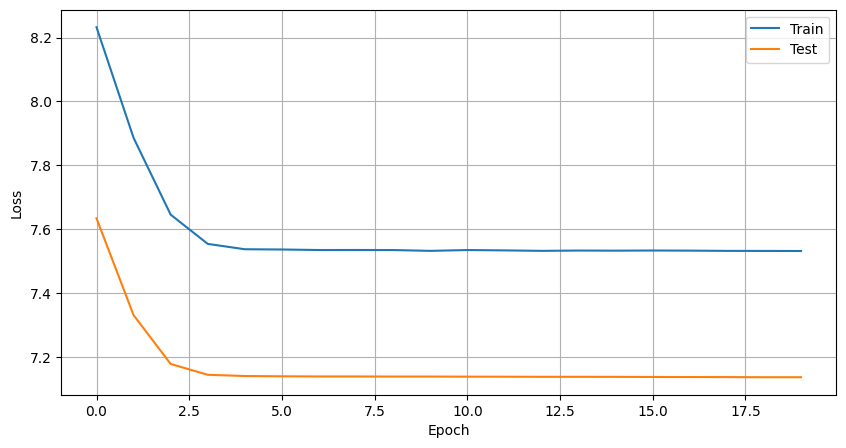

/home/jinchen/git/anl/hmc_ft/2d_u1_rep/cnn_model.py:351: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('models/best_model.pt')


Loaded best model from epoch 18 with loss 7.136010
>>> Saving the trained models
>>> Models saved successfully
>>> Loading the trained models
>>> Models loaded successfully


Running HMC: 100%|██████████| 512/512 [00:40<00:00, 12.52it/s]


>>> Simulation completed


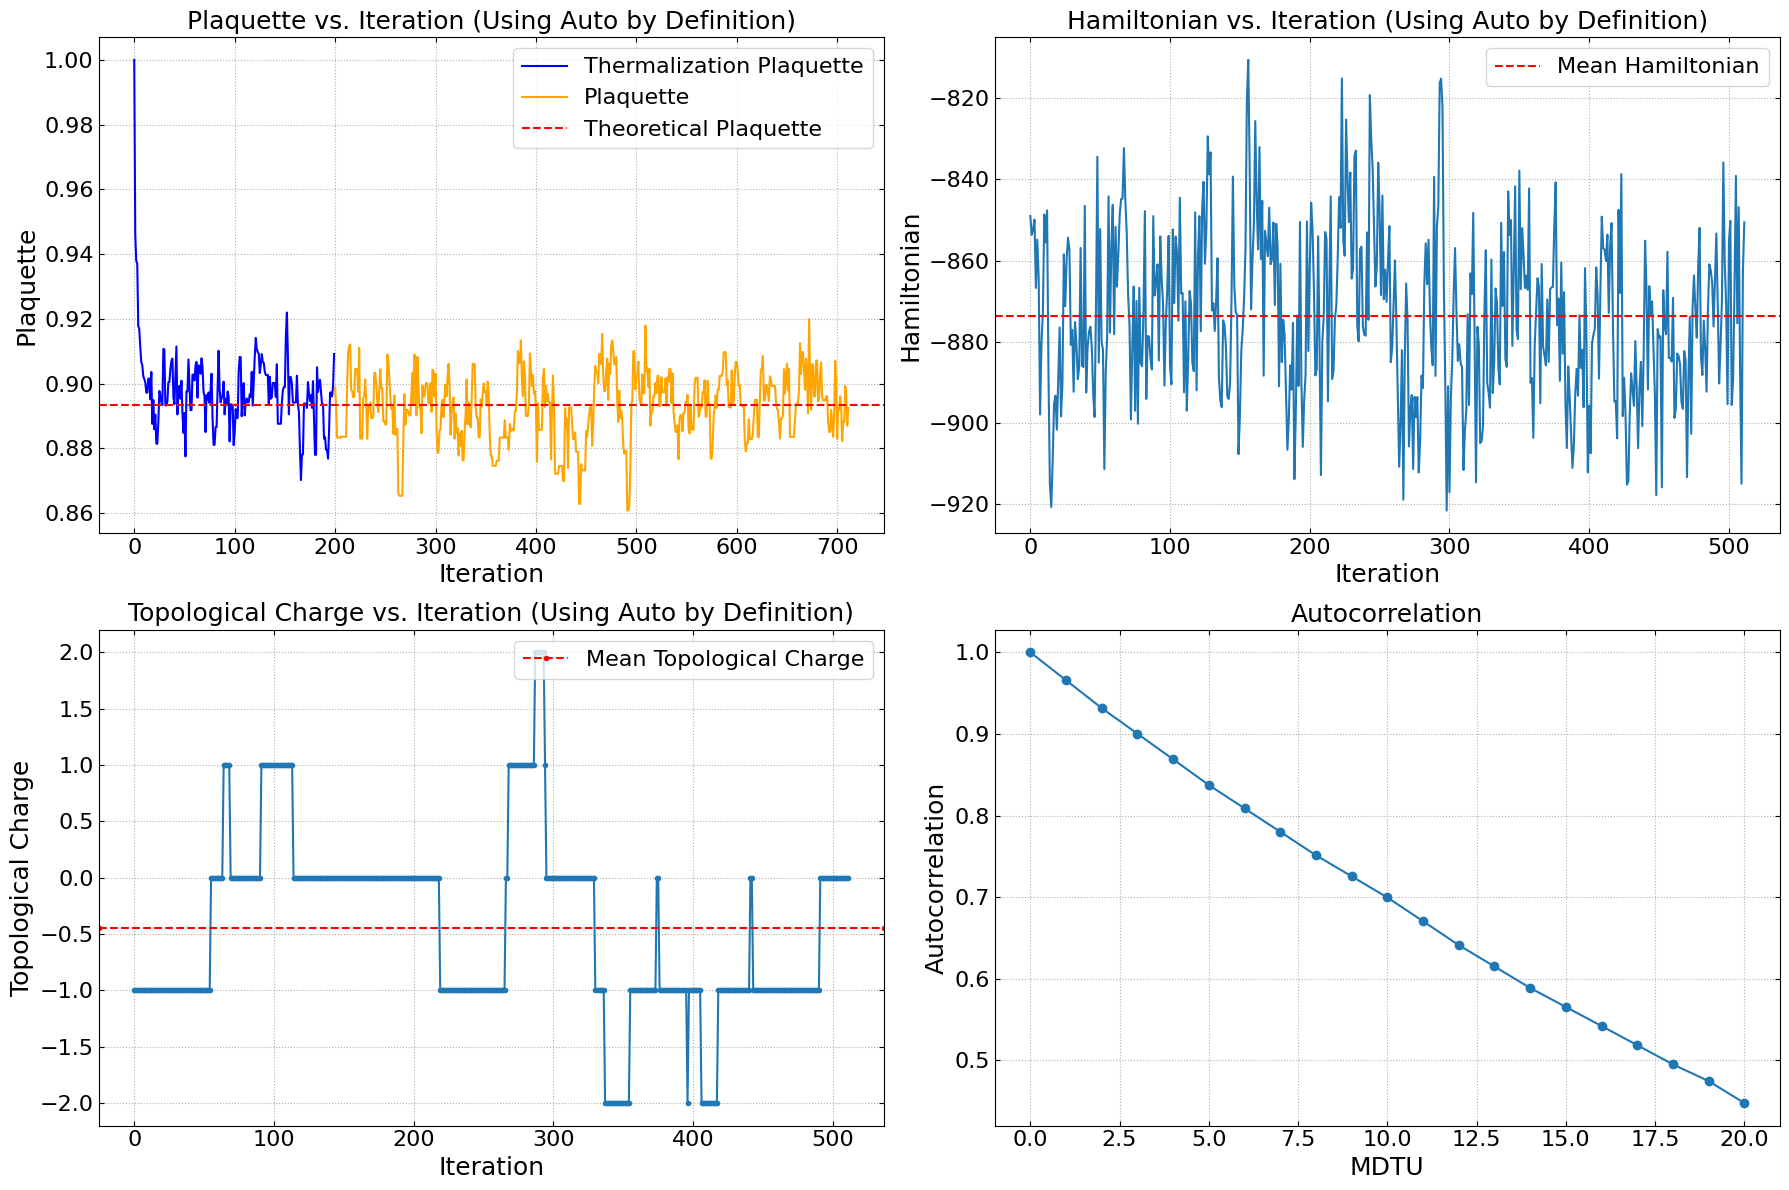

>>> Theoretical plaquette:  0.8933831370440852
>>> Mean plaq:  0.8928423732286319
>>> Std of mean plaq:  0.00045114611430344
Thermalization acceptance rate: 0.8550
Acceptance rate: 0.7520


In [ ]:
print(">>> Neural Network Field Transformation HMC Simulation: ")

# initialize the field transformation
nn_ft = FieldTransformation(lattice_size, device=device)
# nn_ft.model.load_state_dict(torch.load('models/cnn_save.pt'), weights_only=False)

# load the data
data = np.load('dump/theta_ori.npy')
tensor_data = torch.from_numpy(data).float().to(device)
print(f"Loaded data shape: {tensor_data.shape}")

# split the data into training and testing
train_size = int(0.8 * len(tensor_data))
train_data = tensor_data[:train_size]
test_data = tensor_data[train_size:]
print(f"Training data shape: {train_data.shape}")
print(f"Testing data shape: {test_data.shape}")

# train the model
print(">>> Training the model")
nn_ft.train(train_data, test_data, beta, n_epochs=20, batch_size=16)

# Save the trained models
print(">>> Saving the trained models")
torch.save(nn_ft.model.state_dict(), f'models/cnn_trained.pt')
print(">>> Models saved successfully")

# Load the trained models
print(">>> Loading the trained models")
nn_ft.model.load_state_dict(torch.load(f'models/cnn_trained.pt', weights_only=False))
nn_ft.model.eval()
print(">>> Models loaded successfully")


field_transformation = nn_ft.field_transformation
compute_jac_logdet = nn_ft.compute_jac_logdet

# Initialize HMC with field transformation
hmc = HMC_U1_FT(lattice_size, beta, n_thermalization_steps, n_steps, step_size, field_transformation=field_transformation, compute_jac_logdet=compute_jac_logdet, device=device)

# Thermalize the system
theta_thermalized, therm_plaq_ls, therm_acceptance_rate = hmc.thermalize()

# Run HMC without field transformation
final_config, plaq_ls, acceptance_rate, topological_charges, hamiltonians = hmc.run(n_iterations, theta_thermalized)

print(">>> Simulation completed")


# Compute autocorrelation of topological charges
max_lag = 20
hmc_summary(beta, max_lag, volume, therm_plaq_ls, plaq_ls, topological_charges, hamiltonians, therm_acceptance_rate, acceptance_rate)